In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
from scipy.stats import dirichlet
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers 
from jax import random, jit
import jax
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis
from jax import random, vmap
from jax.scipy.stats import norm
import numpyro.distributions as dist
from jax.scipy.special import gammaln
from astropy.cosmology import WMAP9 as cosmo
from scipy.optimize import curve_fit, brentq

In [2]:
array = np.array([1,2,3])
array1 = np.array([1,2,3,4])
array2 = np.array([1,2,3,4,5])
array1 = array1[:,None]
array2 = array2[:,None,None]
print((array+array1+array2).shape)
print()

(5, 4, 3)



In [3]:
# Verify the installation
print("JAX version:", jax.__version__)
print("JAX is using CUDA:", jax.lib.xla_bridge.get_backend().platform)

# Enable 64-bit floating point precision
jax.config.update("jax_enable_x64", True)

# Verify the update
print("jax_enable_x64:", jax.config.read("jax_enable_x64"))

JAX version: 0.4.30
JAX is using CUDA: gpu
jax_enable_x64: True


In [4]:
# Check available devices
print("Available devices:", jax.devices())

# Simple CPU computation test
x = jnp.array([1.0, 2.0, 3.0])
y = jax.device_put(x, jax.devices('gpu')[0])
z = y ** 2
print("Computation result:", z)

Available devices: [cuda(id=0)]


2024-07-24 11:06:30.429350: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Computation result: [1. 4. 9.]


In [5]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [6]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
TARGETID = d['TARGETID'][SEL][~indice]
apr_mag_g = d['APP_MAG_G'][SEL][~indice]
apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]

In [7]:
d_desi = Planck18.distmod(z_desi).value

In [8]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
apr_mag_g = apr_mag_g[indices]
apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
k_gg = k_gg[indices]
k_rr = k_rr[indices]
N_obs = TARGETID.shape[0]
print(N_obs)

157741


In [9]:
apr_mag_g = apr_mag_g.astype(np.float64)
apr_mag_g_err = apr_mag_g_err.astype(np.float64)
k_gg = k_gg.astype(np.float64)

apr_mag_r = apr_mag_r.astype(np.float64)
apr_mag_r_err = apr_mag_r_err.astype(np.float64)
k_rr = k_rr.astype(np.float64)

d_desi = d_desi.astype(np.float64)
z_desi = z_desi.astype(np.float64)

In [10]:
print(get_phis(abs_mag_to_L(np.linspace(-40,0,100)),np.linspace(2.3,2.8,100),"shen20").max())

0.4783756734127197


In [42]:
# Power law efficiency function
def efficiency(x, m0, a, b,c,d,e):
    return jnp.where(x < m0, 1, a*x**-1+b*x**-2+c*x**-3+d*x**-4+e*x**-5-a*m0**-1-b*m0**-2-c*m0**-3-d*m0**-4-e*m0**-5+1)

# Normal PDF
def normal_pdf(x, mean, sigma):
    return (1.0 / (jnp.sqrt(2 * jnp.pi) * sigma)) * jnp.exp(-0.5 * ((x - mean) / sigma)**2)

# Log Poisson
def log_poisson(k, lam):
    log_P = k * jnp.log(lam) - lam - gammaln(k + 1)
    return log_P
# Phi function
def phi(m, z_samples, z_interval, x, z_desi, k_rr):
    z1 = z_samples - 0.1
    z2 = z_samples + 0.1
    k_mean = jnp.array([jnp.mean(k_rr[(z_desi > z1_i) & (z_desi < z2_i)]) for z1_i, z2_i in zip(z1, z2)])
    #print(k_mean)
    new_z = (z1 + z2) / 2
    new_d = Planck18.distmod(new_z).value
    L = abs_mag_to_L(m - k_mean - new_d + x)
    phi_value = 0.4 * get_phis(L, new_z, "shen20")
    return phi_value

# Integral function
def integral(k, d_desi, x, mag_apr, magerr, z_desi, m0, a, b, c,d,e, num_samples):
    M_T = jnp.linspace((mag_apr - k - d_desi).min(), (mag_apr - k - d_desi).max(), num_samples)
    y_samples = jnp.linspace(mag_apr.min(), mag_apr.max(), num_samples)

    L = abs_mag_to_L(M_T[:, None] + x)
    integrand = efficiency(mag_apr, m0, a,b,c,d,e) * normal_pdf(mag_apr, M_T[:, None] + k + d_desi, magerr) * get_phis(L, z_desi, "shen20")
    numerator = jnp.trapezoid(integrand, M_T, axis=0)

    def inner_integral(y):
        L_inner = abs_mag_to_L(M_T[:, None] + x)
        integrand_inner = efficiency(y, m0,a, b,c,d,e) * normal_pdf(y, M_T[:, None] + k + d_desi, magerr) * get_phis(L_inner, z_desi, "shen20")
        return jnp.trapezoid(integrand_inner, M_T, axis=1)

    integrand1 = inner_integral(y_samples[:, None, None])
    denominator = jnp.trapezoid(integrand1, y_samples, axis=0)
    log_likelihood = jnp.log(numerator / denominator)
    return log_likelihood

# N_pre function
def N_pre(x, m0, a, b, c,d,e,num_samples, apr_mag_r, z_desi, k_rr):
    m_samples = np.linspace(apr_mag_r.min(), apr_mag_r.max(), num_samples)
    z_samples = np.linspace(z_desi.min(), z_desi.max(), num_samples)
    m_interval = m_samples[1] - m_samples[0]
    z_interval = z_samples[1] - z_samples[0]
    comoving_volume = cosmo.comoving_volume(z_samples).value
    integrand = phi(m_samples[:, None], z_samples, z_interval, x, z_desi, k_rr) * efficiency(m_samples[:, None], m0, a, b, c,d,e)
    integrand1 = jnp.trapezoid(integrand, m_samples, axis=0)
    integral2 = jnp.trapezoid(integrand1, comoving_volume, axis=0)
    #print(phi(m_samples[:, None], z_samples, z_interval, x, z_desi, k_rr))
    return integral2

# Define the model using NumPyro
def model(k, d, mag_apr, magerr, z, N_obs, num_samples1=100,num_samples2=100):
    x = numpyro.sample('x', dist.Uniform(-4, 0))
    m0 = numpyro.sample('m0', dist.Uniform(17, 30))
    #a = numpyro.sample('a', dist.Normal(341, 100))  
    #b = numpyro.sample('b', dist.Normal(-15431, 1000))
    #c = numpyro.sample('c', dist.Normal(175605, 10000))
    #d = numpyro.sample('d',dist.Normal(7726222951,10000))
    #e = numpyro.sample('e',dist.Normal(-39661711764.52863,10000))
    log_L = 15*jnp.sum(integral(k, d, x, mag_apr, magerr, z, m0, -43523.57005582172, 3582001.777523236, -110246272.6467956, 1503395024.3432527, -7660087322.770382, num_samples2)) + log_poisson(N_obs, 0.16 * N_pre(x, m0,-43523.57005582172, 3582001.777523236, -110246272.6467956, 1503395024.3432527, -7660087322.770382, num_samples1, apr_mag_r, z_desi, k_rr))
    numpyro.factor('log_L', log_L)

In [43]:
i_start = 0
i_end = i_start+10000
print(log_poisson(N_obs,0.16*N_pre(-2.1128,18.9402, 369.9613,-15315.1589,171307.9595,100, apr_mag_r[i_start:i_end], z_desi[i_start:i_end], k_rr[i_start:i_end])),jnp.sum(integral(k_rr[i_start:i_end], d_desi[i_start:i_end], -2.1128, apr_mag_r[i_start:i_end], apr_mag_r_err[i_start:i_end], z_desi[i_start:i_end], 18.9402, 369.9613,-15315.1589,171307.9595, 200)))
print(log_poisson(N_obs,0.16*N_pre(-1.85,18.69,341.6311745637932,-15431.338499631529,175605.04707892935,100, apr_mag_r[i_start:i_end], z_desi[i_start:i_end], k_rr[i_start:i_end])),jnp.sum(integral(k_rr[i_start:i_end], d_desi[i_start:i_end], -1.85, apr_mag_r[i_start:i_end], apr_mag_r_err[i_start:i_end], z_desi[i_start:i_end], 18.69,341.6311745637932,-15431.338499631529,175605.04707892935, 200)))
print(log_poisson(N_obs,0.16*N_pre(-1.9116,18.7099,341.6311745637932,-15431.338499631529,175605.04707892935,100, apr_mag_r[i_start:i_end], z_desi[i_start:i_end], k_rr[i_start:i_end])),jnp.sum(integral(k_rr[i_start:i_end], d_desi[i_start:i_end], -1.9116, apr_mag_r[i_start:i_end], apr_mag_r_err[i_start:i_end], z_desi[i_start:i_end], 18.7099,341.6311745637932,-15431.338499631529,175605.04707892935, 200)))

TypeError: N_pre() missing 2 required positional arguments: 'z_desi' and 'k_rr'

In [44]:
rng_key = random.PRNGKey(0)
# Sampler configuration
num_warmup, num_samples = 5000, 10000
i_start = 0
i_end = i_start+1000
# Initialize batch parameters for the entire datasetw

init_params = {
    'x': -1.85 * jnp.ones((1,)),  
    'm0': 18.69 * jnp.ones((1,)),
    'a': 341 * jnp.ones((1,)),
    'b': -15431 * jnp.ones((1,)),
    'c': 175605 * jnp.ones((1,)),
}

# Set up the NUTS sampler
kernel = NUTS(model, target_accept_prob=0.8)
#kernel = HMC(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1, jit_model_args=True, progress_bar=True)

# Run the sampler over thswwe entire dataset
#mcmc.run(rng_key, apr_mag_g, apr_mag_g_err, k_gg, apr_mag_r, apr_mag_r_err, k_rr, d,z, 22.5, init_params=init_params)
mcmc.run(rng_key, k_rr[i_start:i_end], d_desi[i_start:i_end], apr_mag_r[i_start:i_end], apr_mag_r_err[i_start:i_end], z_desi[i_start:i_end],N_obs)
# Get samples
samples = mcmc.get_samples()
# Optionally, process or save your samples
print(samples)

sample: 100%|██████████| 15000/15000 [02:24<00:00, 103.58it/s, 3 steps of size 2.33e-01. acc. prob=0.90] 


{'m0': Array([18.98974678, 18.98916695, 18.98952181, ..., 18.99137759,
       18.99162257, 18.99259069], dtype=float64), 'x': Array([-1.97512699, -1.97597681, -1.97493285, ..., -1.99168281,
       -1.9913899 , -1.98646762], dtype=float64)}


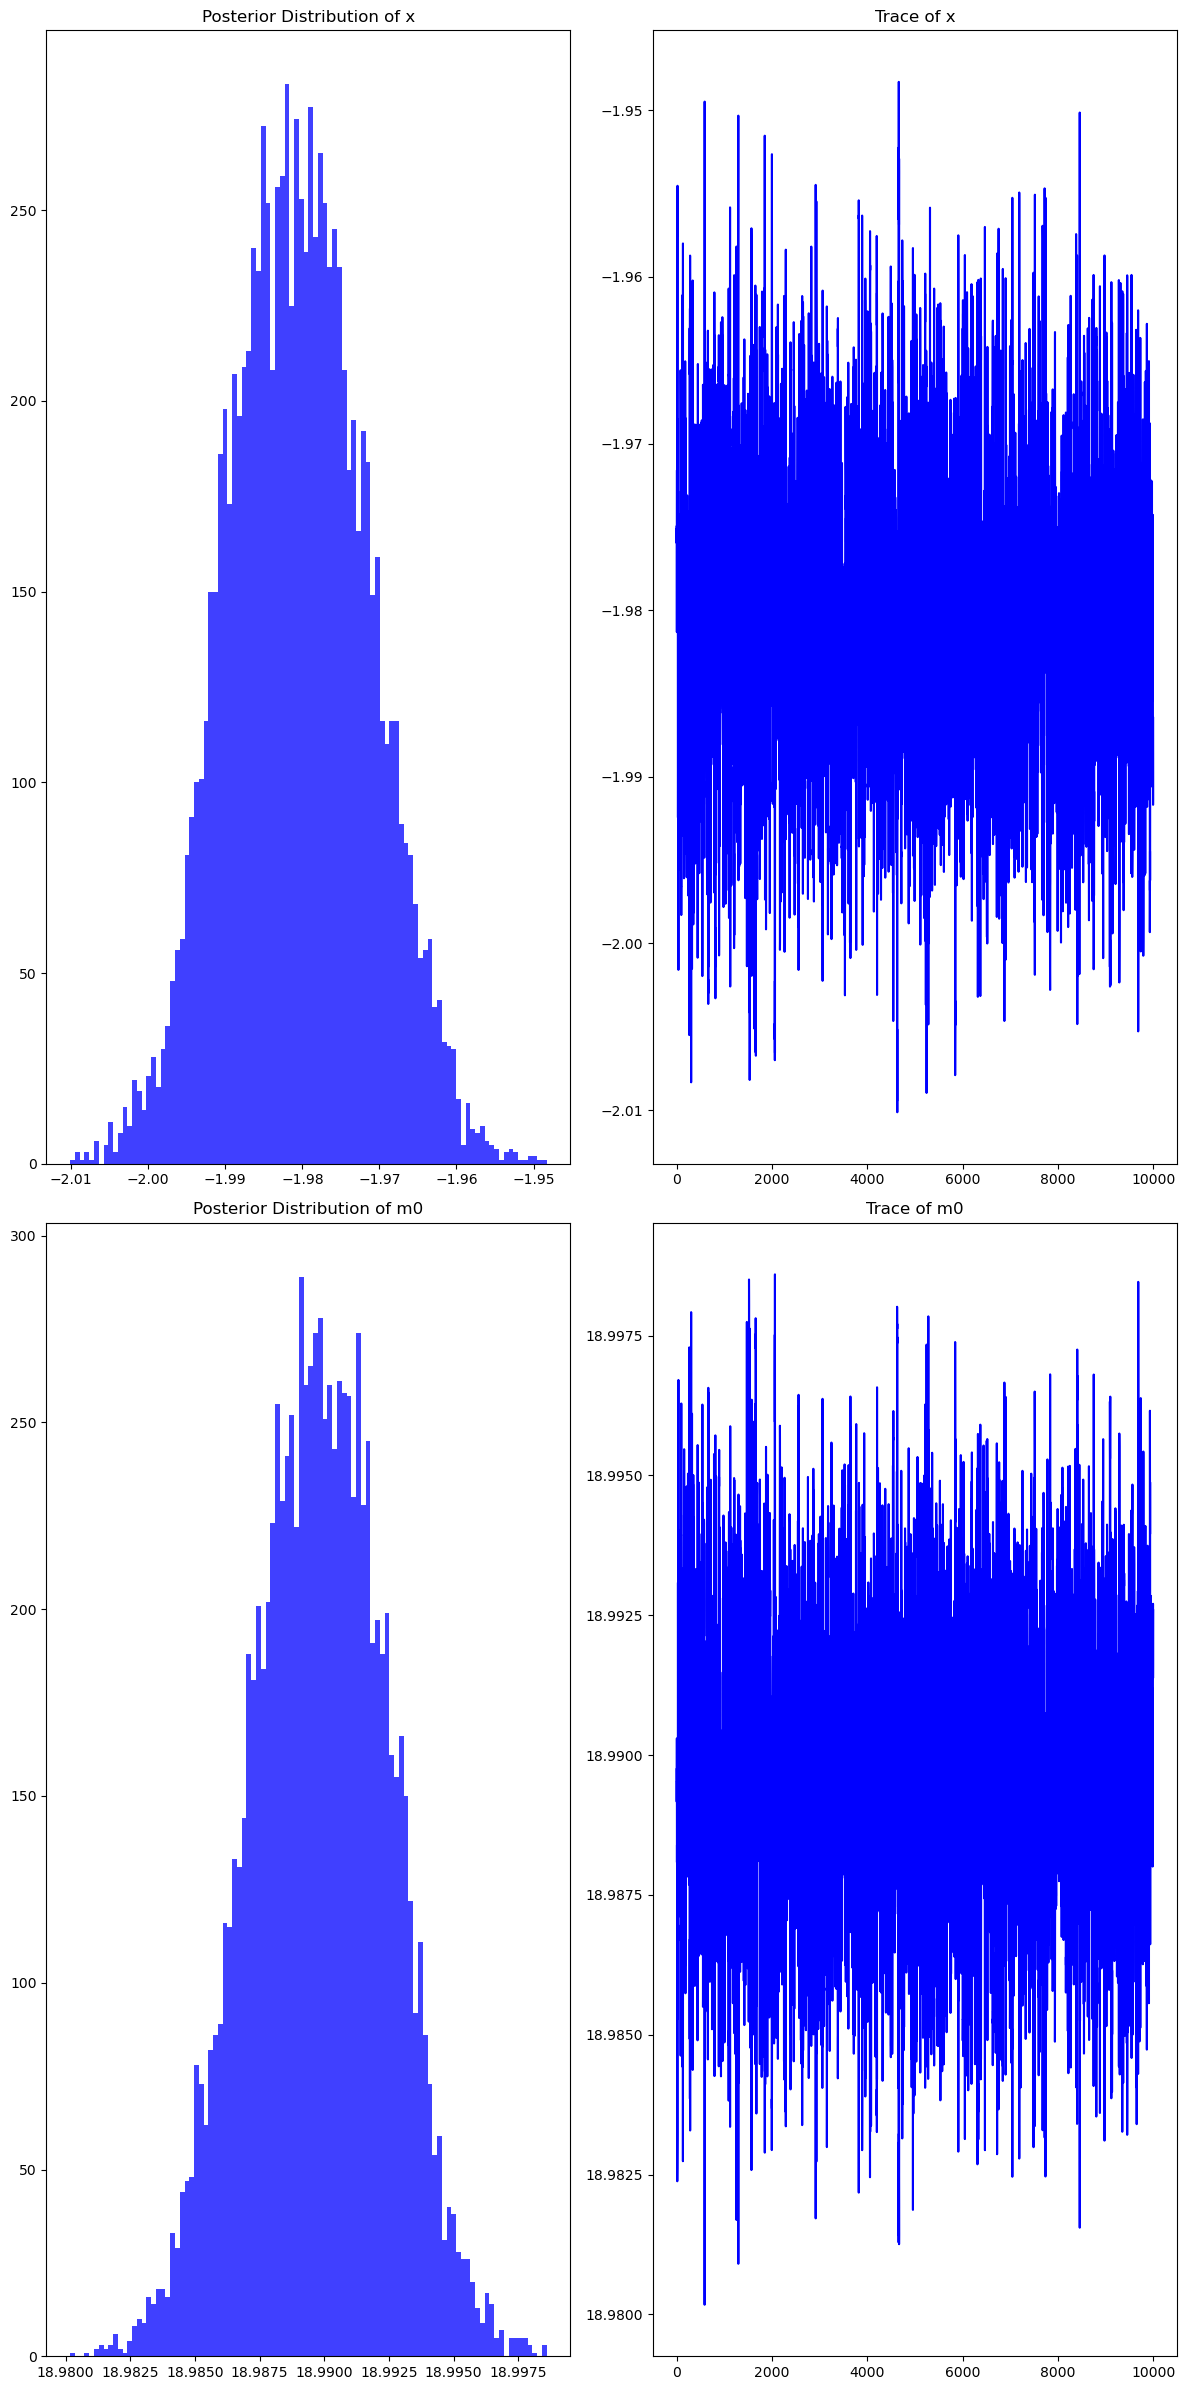

In [45]:
# Extract the chains and parameters
x = samples['x']
m0 = samples['m0']
#a = samples['a']
#b = samples['b']
#c = samples['c']
# Creating a figure to hold the subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 24))  

# Helper function to plot histograms and traces
def plot_param(ax, data, title):
    ax[0].hist(data, bins=100, alpha=0.75, color='blue')
    ax[0].set_title(f'Posterior Distribution of {title}')
    ax[1].plot(data, color='blue')
    ax[1].set_title(f'Trace of {title}')

# Plotting each parameter
plot_param(axs[0], x, 'x')
plot_param(axs[1], m0, 'm0')
#plot_param(axs[2],a,'a')
#plot_param(axs[3],b,'b')
#plot_param(axs[4],c,'c')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

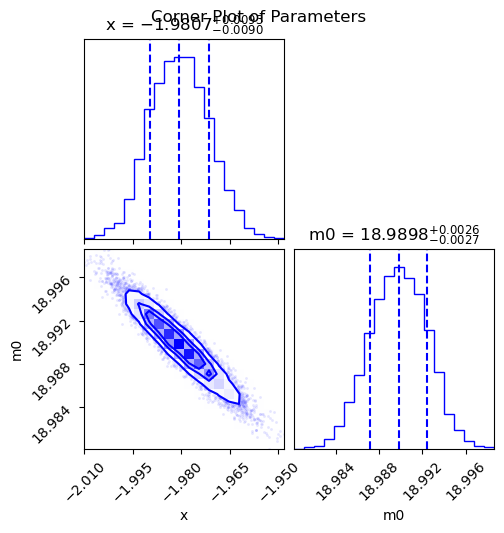

In [46]:
import corner
# Extract samples for plotting
#samples = np.vstack((x, m0)).T
samples = np.vstack((x,m0)).T
# Create a corner plot
fig = corner.corner(samples, labels=['x', 'm0','a','b','c'], 
                    show_titles=True,quantiles=[0.16, 0.5, 0.84],
                       plot_contours=True, color='blue', title_kwargs={"fontsize": 12},title_fmt=".4f")

fig.suptitle('Corner Plot of Parameters')
fig.show()